In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import log_loss
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, log_loss, confusion_matrix, roc_curve, auc, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
# Load your scaled data
df_train = pd.read_csv('/content/drive/MyDrive/AI ML Project/Train_data_4M.csv')
df_val = pd.read_csv('/content/drive/MyDrive/AI ML Project/Val_data_4M')

# Prepare the datasets
X_train = df_train.drop('click', axis=1)
y_train = df_train['click']
X_val = df_val.drop('click', axis=1)
y_val = df_val['click']


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.5; total time=  49.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.5; total time=  43.9s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.5; total time=  45.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.5; total time=  18.8s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.5; total time=  21.3s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.5; total time=  18.7s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, n_estimators=300, subsample=1.0; total time=  24.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=6, n_estimators=300, subsample=1.0; total time=  21.6s
[CV] END c

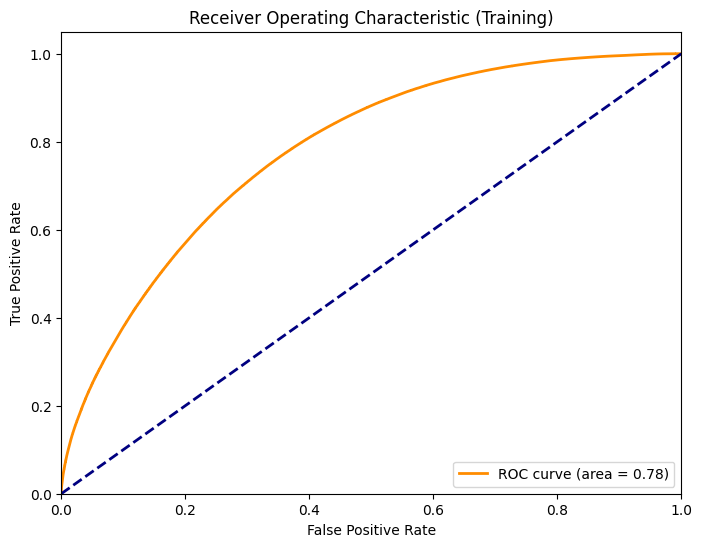

Performance of XGBClassifier on Validation Dataset:
Accuracy: 0.835269
Log Loss: 0.394348479515424
F1 Score: 0.7803334467986195
Classification Report:
              precision    recall  f1-score         support
0              0.841065  0.988317  0.908765   830114.000000
1              0.604986  0.087429  0.152780   169886.000000
accuracy       0.835269  0.835269  0.835269        0.835269
macro avg      0.723025  0.537873  0.530772  1000000.000000
weighted avg   0.800958  0.835269  0.780333  1000000.000000
Confusion Matrix:
[[820416   9698]
 [155033  14853]]


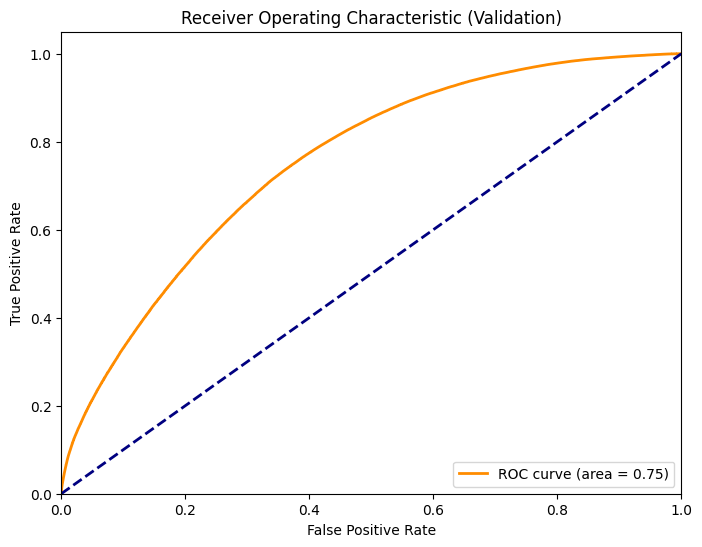

In [5]:
# Function to evaluate performance
def evaluate_performance(clf, X, y, dataset_name):

    # Predict classes and probabilities
    y_pred = clf.predict(X)
    y_pred_probs = clf.predict_proba(X)[:, 1]

    # Calculate metrics
    log_loss_value = log_loss(y, y_pred_probs)
    report = classification_report(y, y_pred, output_dict=True)
    f1_score = report['weighted avg']['f1-score']
    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    fpr, tpr, thresholds = roc_curve(y, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Print and plot metrics
    print(f"Performance of {clf.__class__.__name__} on {dataset_name} Dataset:")
    print(f"Accuracy: {accuracy}\nLog Loss: {log_loss_value}\nF1 Score: {f1_score}")
    print("Classification Report:")
    print(pd.DataFrame(report).transpose())
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic ({dataset_name})')
    plt.legend(loc="lower right")
    plt.show()

# Define XGBoost classifier and hyperparameter grid
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_log_loss',
    cv=3,
    verbose=2,
    random_state=42
)
# Fit the model
random_search.fit(X_train, y_train)

# Evaluate the best model
best_xgb = random_search.best_estimator_
evaluate_performance(best_xgb, X_train, y_train, "Training")
evaluate_performance(best_xgb, X_val, y_val, "Validation")